# Exercises: Time Series Exploratory Analysis 

<hr style="border:2px solid gray">

### Part I: Store Data
- you will need to choose a method of aggregating such that each observation is a unique date
- choose a method of splitting your data
- only explore the training split.
<br>

### Part II: Germany Data
- choose a method of splitting your data
- only explore the training split.

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

import prepare
import acquire

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)

<hr style="border:2px solid gray">

## Part I: Store Data

In [2]:
#bring in the dataframe using our function in acquire module
df = acquire.get_store_data()

#take a look
df.sample(3)

,sale_date,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode
38227,2017-09-04,40,Earths Best,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,12125 Alamo Ranch Pkwy,78253
910134,2015-02-26,37,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.20,735 SW Military Dr,78221
401055,2016-03-07,71,Betty Crocker,Betty Crocker Twin Pack Real Potatoes Scallope...,7.31,8503 NW Military Hwy,78231


In [3]:
#make changes to the df using our function in prepare module
store_df= prepare.prep_store_data()

#take a look
store_df.sample(3)

,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode,month,day_of_week,sales_total
sale_date,,,,,,,,,
2014-11-21,18,Bear Naked,Bear Naked Fit Almond Crisp 100 Percent Natura...,7.38,15000 San Pedro Ave,78232,November,Friday,132.84
2016-12-21,13,Bear Naked,Bear Naked Fit Almond Crisp 100 Percent Natura...,7.38,12018 Perrin Beitel Rd,78217,December,Wednesday,95.94
2013-11-28,47,Suave,Suave Naturals Moisturizing Body Wash Creamy T...,9.11,12018 Perrin Beitel Rd,78217,November,Thursday,428.17


In [4]:
#take a look at the min date and max date
store_df.index.min(), store_df.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

<b> Percentage Based Split</b>

In [5]:
#use percentage-based data split
train_size = .70

#n is the entire number of entries in the dataframe
n = store_df.shape[0]

#look at what n is (total entries in the df)
n

913000

In [6]:
#set the test size to 70% * total number of entries 
test_start_index = round(train_size * n)

#take a look (70% of entire df)
test_start_index

639100

In [7]:
#everything up (not including) to the test_start_index
perc_train = store_df[:test_start_index]

#everything from the test_start_index to the end
perc_test = store_df[test_start_index:] 

<b> Manual Split</b>

In [8]:
# Train test split:
man_train = store_df[:'2016']
man_test = store_df['2017']

In [9]:
man_train.shape, man_test.shape

((730500, 9), (182500, 9))

<b>Visualize with percentage-based split</b>

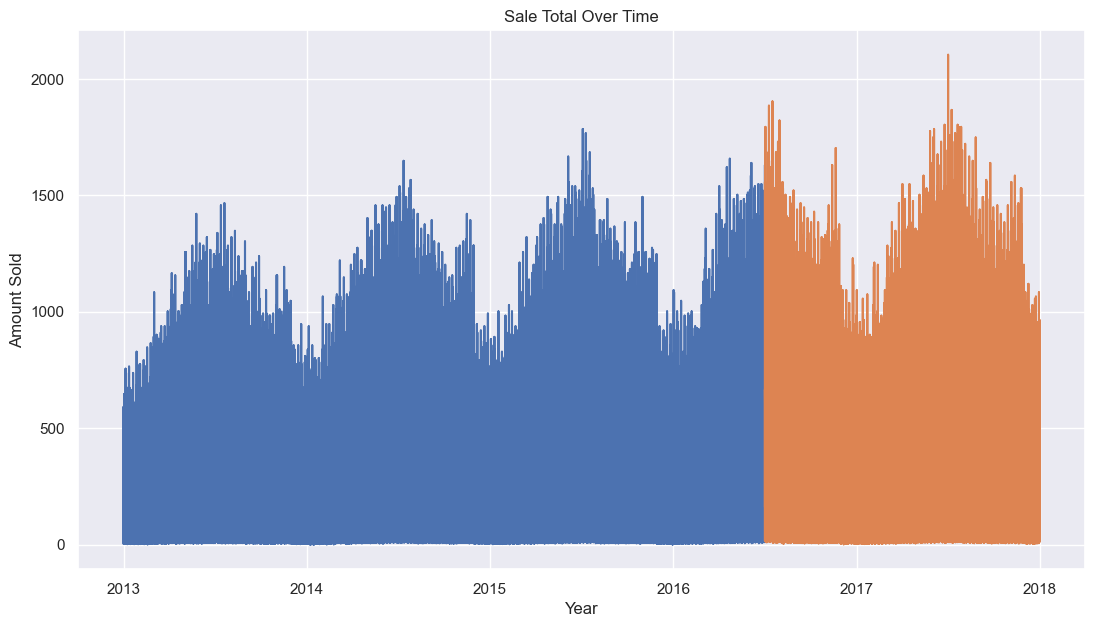

In [10]:
#plot train with target of sale amount
plt.plot(perc_train.index, perc_train.sales_total)
#plot test with target of sale amount
plt.plot(perc_test.index, perc_test.sales_total)

plt.title('Sale Total Over Time')

plt.ylabel('Amount Sold')
plt.xlabel('Year')

None

In [11]:
y = perc_train.sales_total.resample('D').mean()
y.head()

sale_date
2013-01-01    147.68802
2013-01-02    147.14116
2013-01-03    156.33896
2013-01-04    168.93546
2013-01-05    175.24370
Freq: D, Name: sales_total, dtype: float64

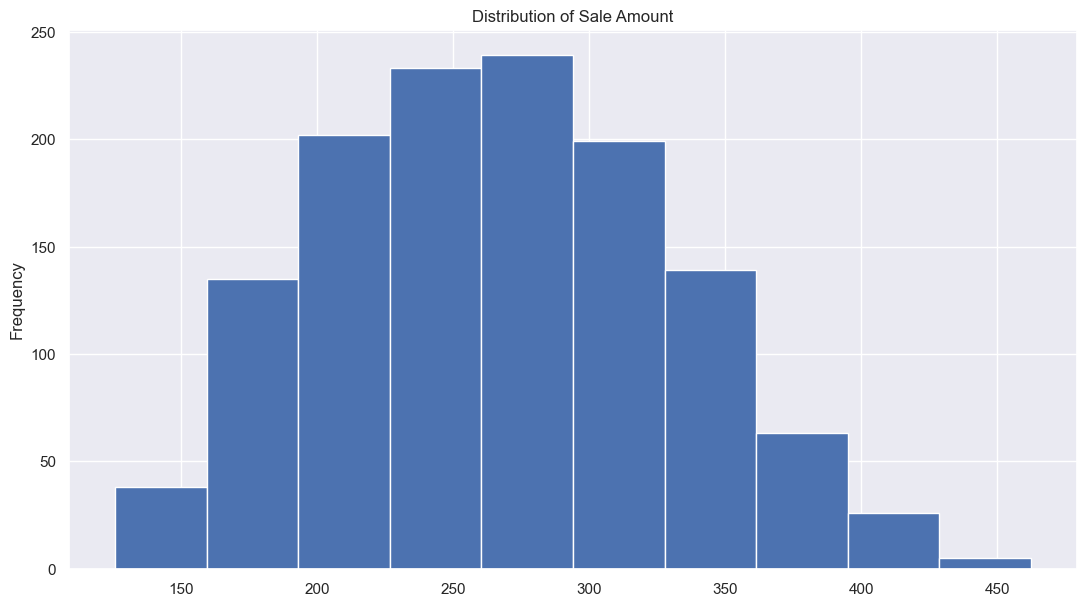

In [12]:
y.plot.hist()
plt.title('Distribution of Sale Amount')
plt.show()
#this shows a normal distribution with a right skew

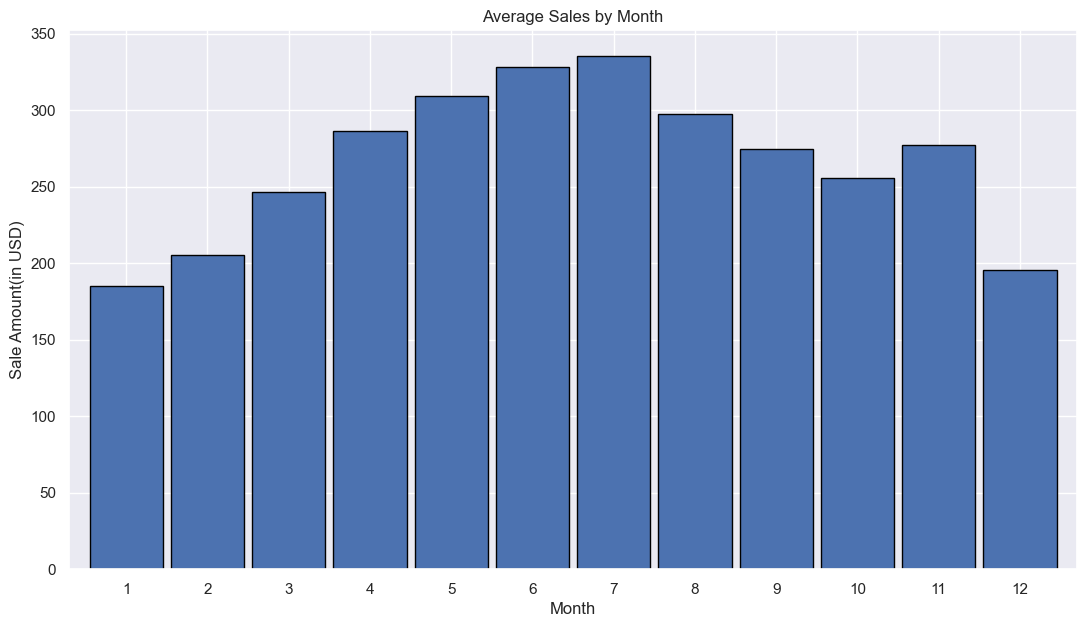

In [13]:
#graph average monthly sales
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales by Month', xlabel='Month', ylabel='Sale Amount(in USD)')
plt.show()

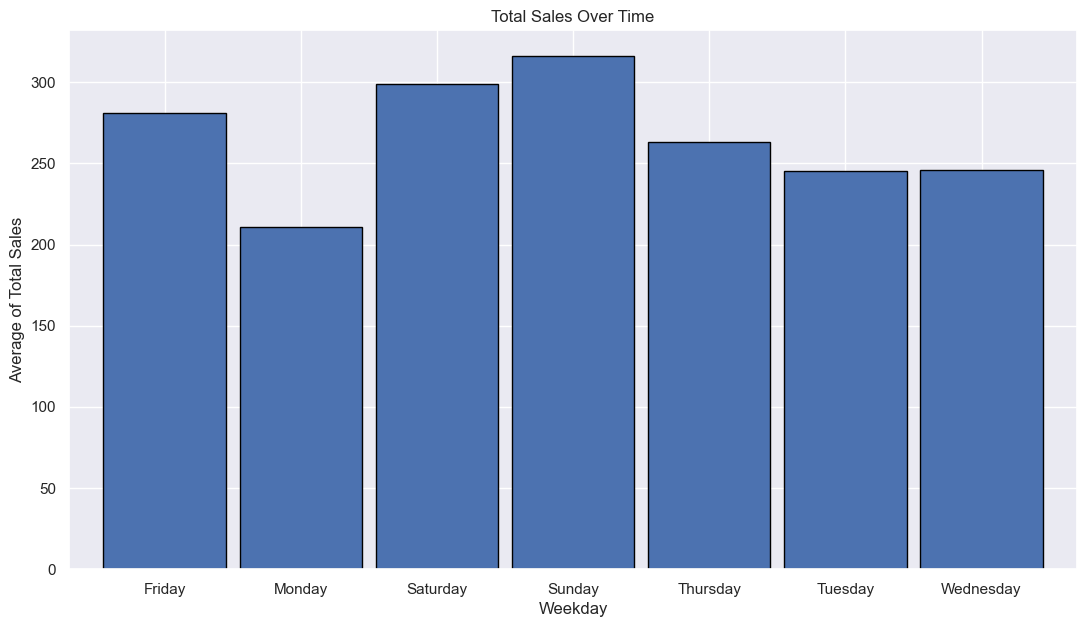

In [14]:
#graph average daily slaes
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Total Sales by Weekday', xlabel='Weekday', ylabel='Sales (in USD)')
plt.title('Total Sales Over Time')
plt.xlabel('Weekday')
plt.ylabel('Average of Total Sales')
plt.show()

<AxesSubplot:xlabel='weekday', ylabel='sales_total'>

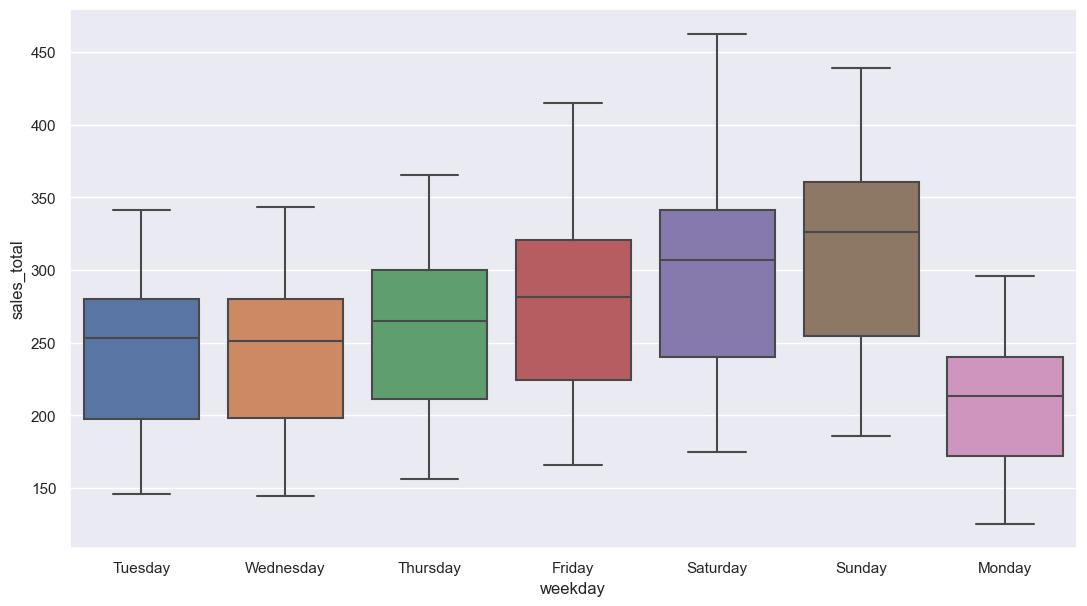

In [15]:
(y.reset_index().assign(weekday=lambda store_df: store_df.sale_date.dt.day_name()).pipe((sns.boxplot, 'data'), y='sales_total', x='weekday'))

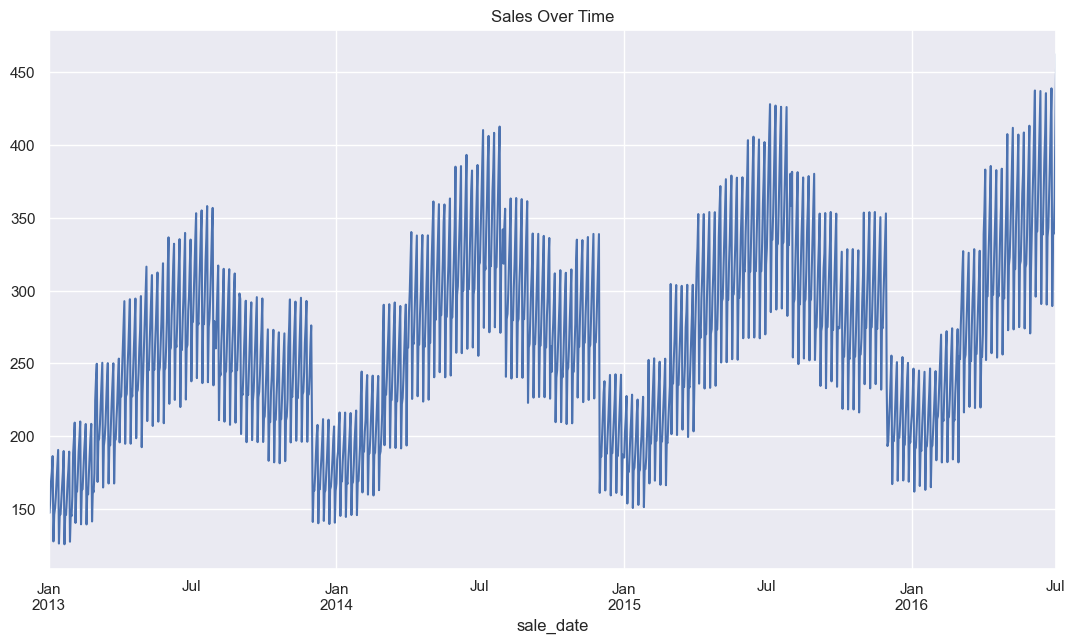

In [16]:
y.plot()
plt.title('Sales Over Time')
None

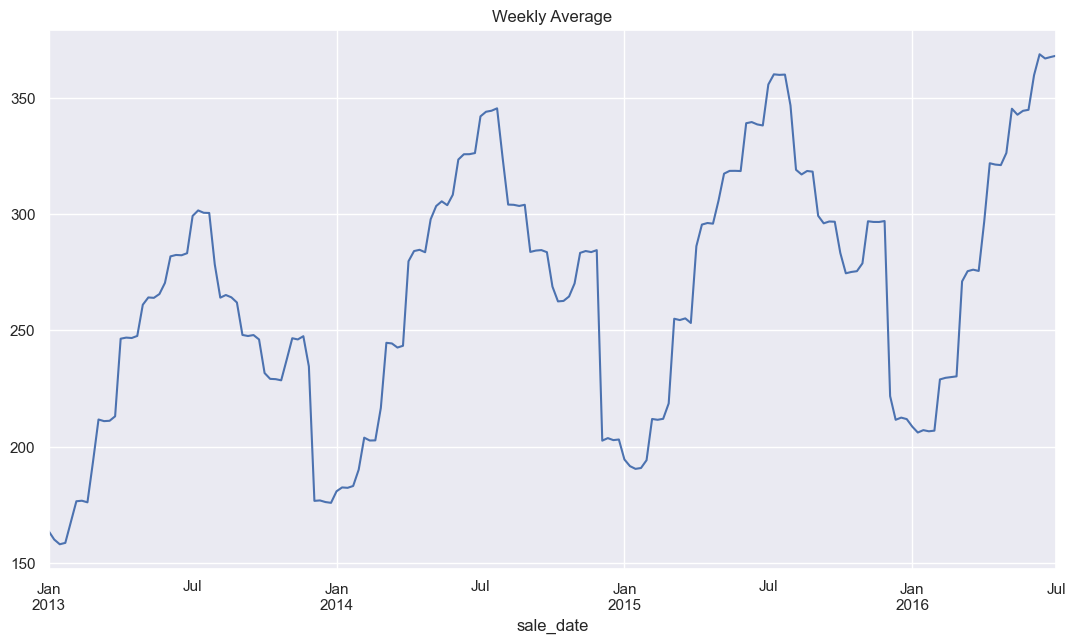

In [17]:
y.resample('W').mean().plot(title='Weekly Average')
None

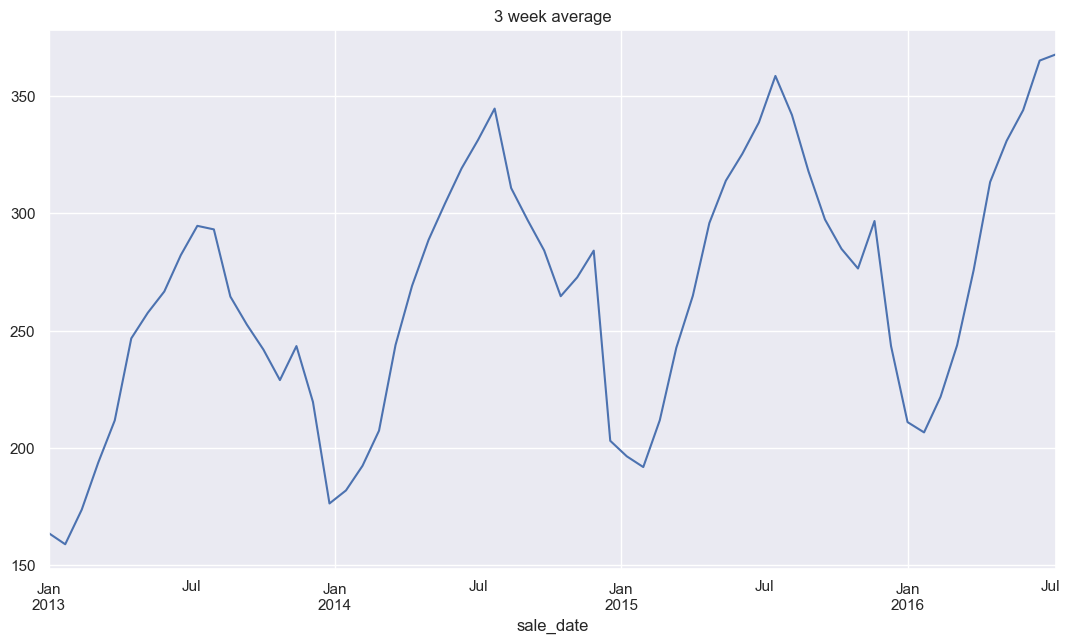

In [18]:
y.resample('3W').mean().plot(title='3 week average')
None

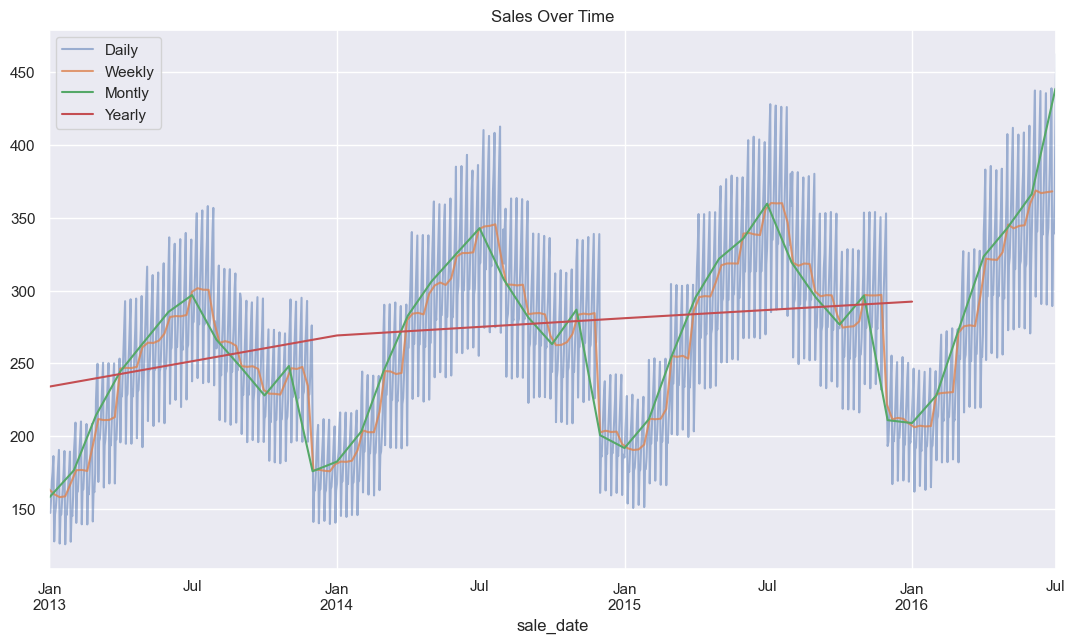

In [19]:
#y.plot(alpha=.2, label='Hourly') - There is no hourly data
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.title('Sales Over Time')
plt.legend()

None

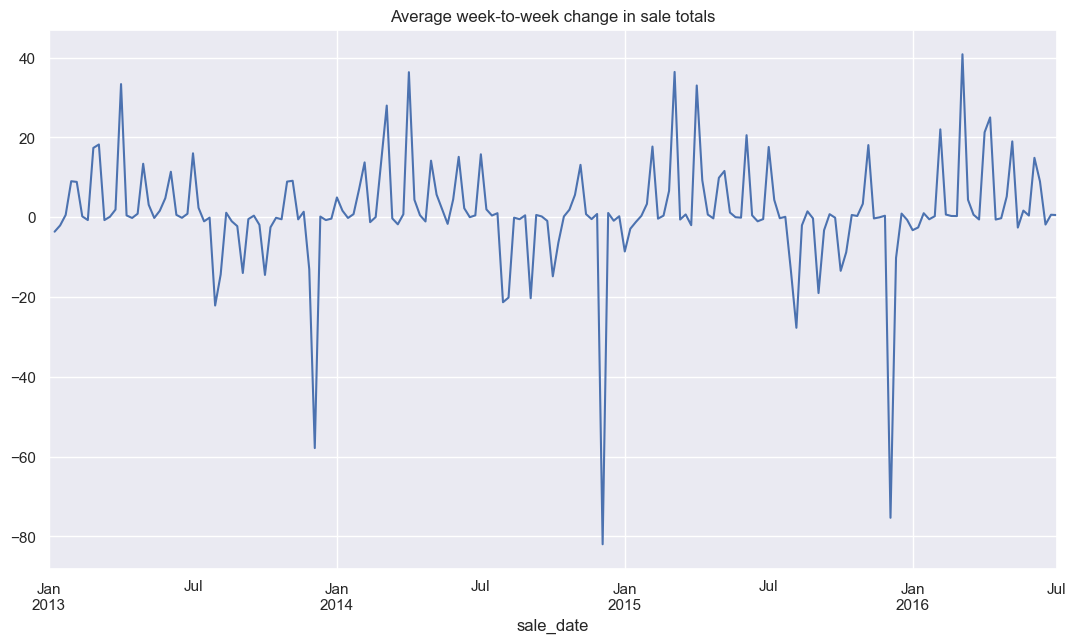

In [20]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in sale totals')
None

<AxesSubplot:title={'center':'Average month-to-month change in sale tota'}, xlabel='sale_date'>

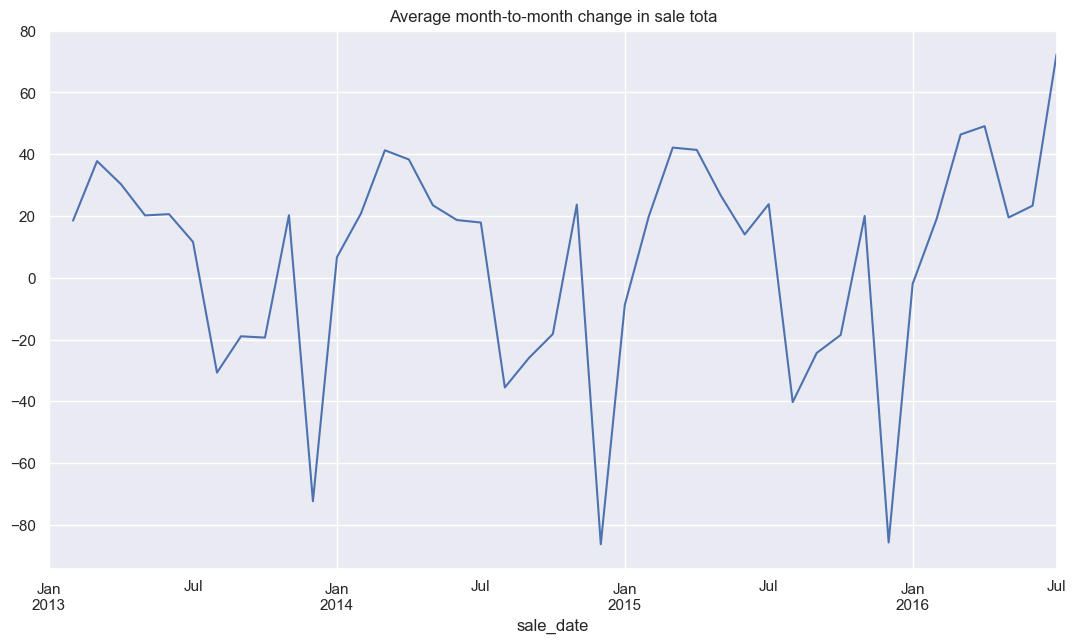

In [21]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in sale tota')

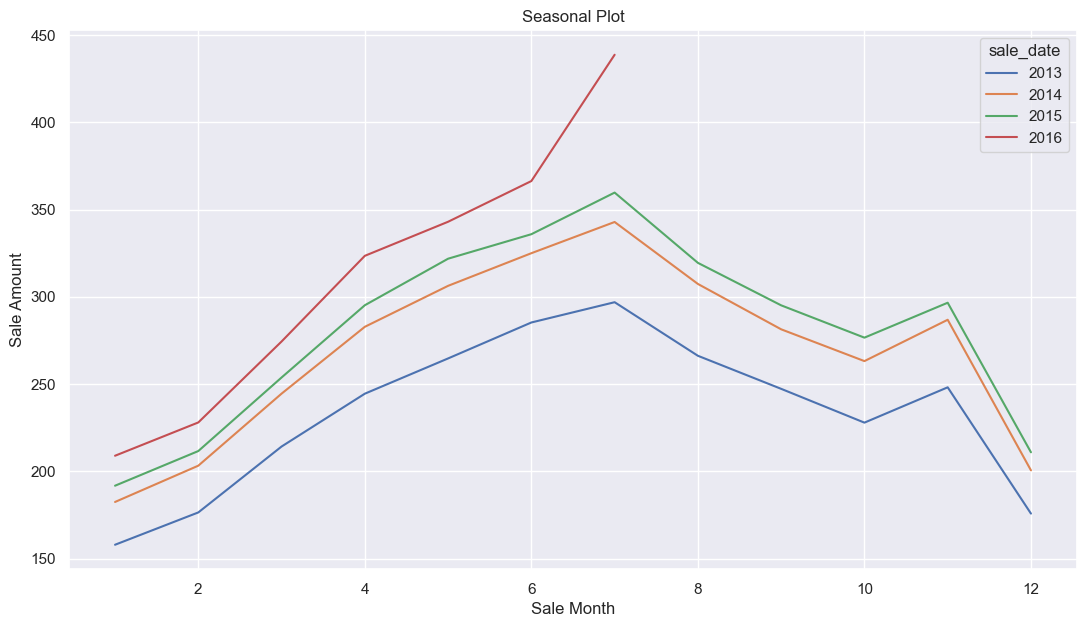

In [22]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')
plt.ylabel('Sale Amount')
plt.xlabel('Sale Month')
None

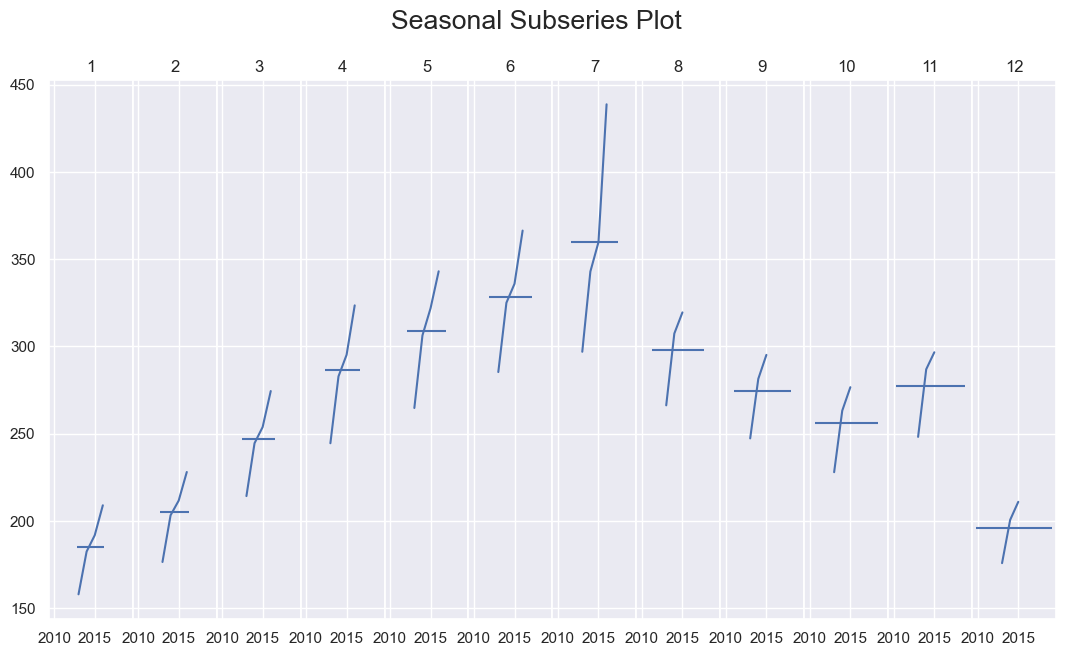

In [23]:
#Seasonal Subseries Plot
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

#super-title for the overall figure
fig.suptitle('Seasonal Subseries Plot') 
fig.subplots_adjust(wspace=0)

<hr style="border:2px solid gray">

## Part II: Germany Data

In [24]:
#acquire germany data using function in acquire module
germany = acquire.get_germany_data()

In [25]:
#take a look
germany.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [26]:
#bring in correct germany df using function in prepare module
germany_df = prepare.prep_germany_data()

In [27]:
germany_df.sample(3)

,consumption,wind,solar,wind_solar,month,day_of_week,year
Date,,,,,,,
2013-07-23,1292.027,50.439,173.505,223.944,July,Tuesday,2013
2013-09-12,1343.379,20.095,60.910,81.005,September,Thursday,2013
2009-07-09,1245.298,0.000,0.000,0.000,July,Thursday,2009


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>

- Nulls have been filled with 0
- Date datatype has been converted and has been set as index
- we have created new columns for month, weekday and year
    
</div>

<b>Percentage Based Split</b>

In [28]:
#determine percent size of train
train_size = .70
#set n to all entries in the dateframe
n = germany_df.shape[0]
#set where test should start
test_start_index = round(train_size * n)

#everything up (not including) to the test_start_index
train = germany_df[:test_start_index] 
#everything from the test_start_index to the end
test = germany_df[test_start_index:] 

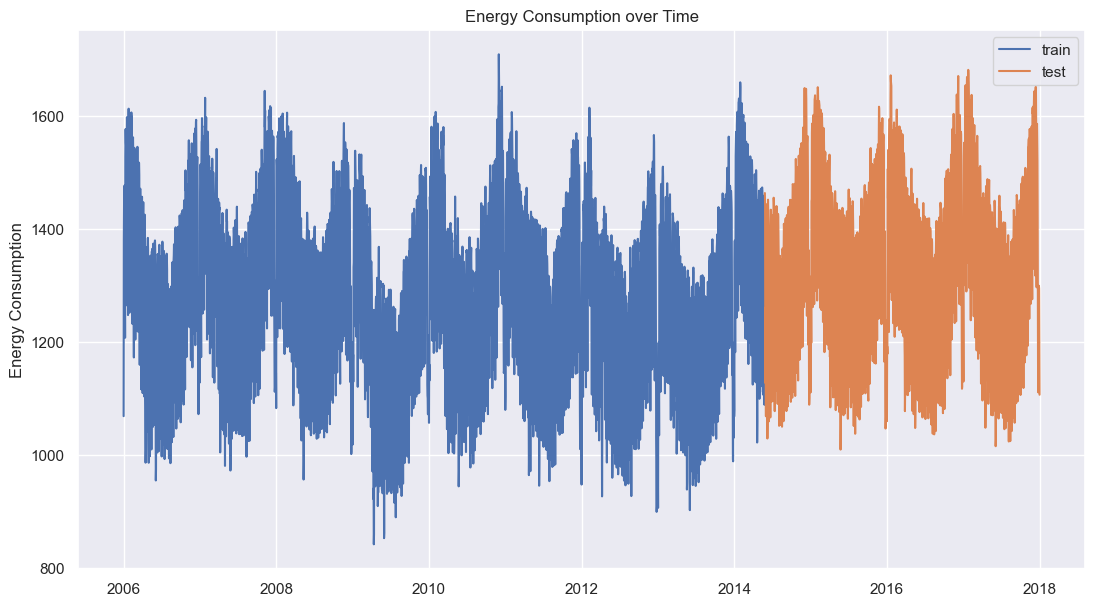

In [29]:
#visualize train and test consumption over time
plt.plot(train.index, train.consumption)
plt.plot(test.index, test.consumption)

plt.title('Energy Consumption over Time')
plt.ylabel('Energy Consumption')
plt.legend(['train','test'])
plt.show()

<b>Visualizations using percentage based split</b>

In [30]:
#assigning consumption in the train set to y
y = train.consumption

#take a look
y.head()

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: consumption, dtype: float64

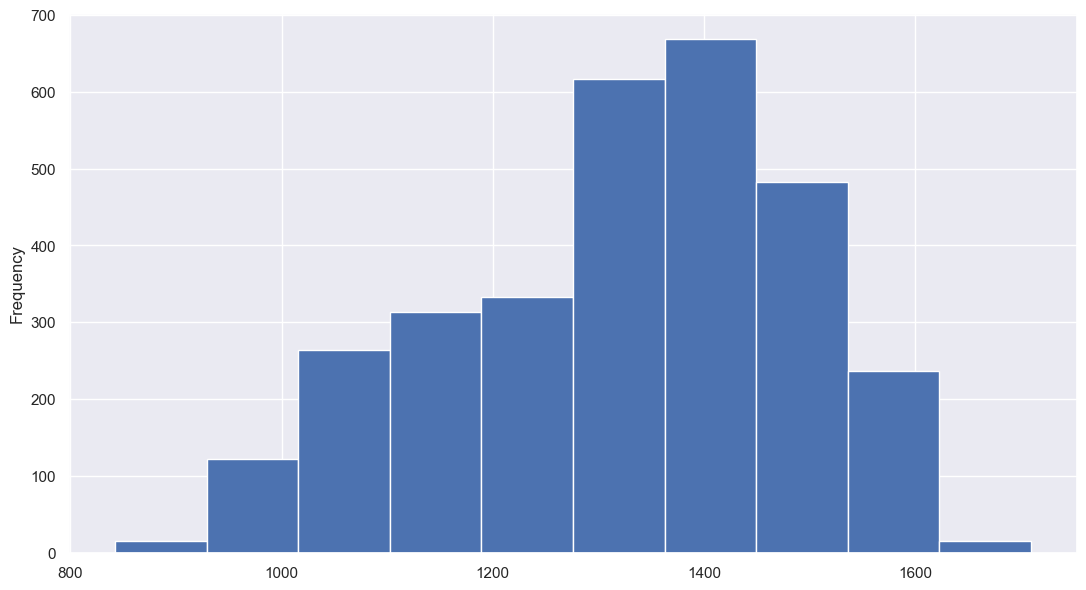

In [31]:
#plot distribution of target variable
y.plot.hist()
plt.show()

#shows normal distribution with left skew

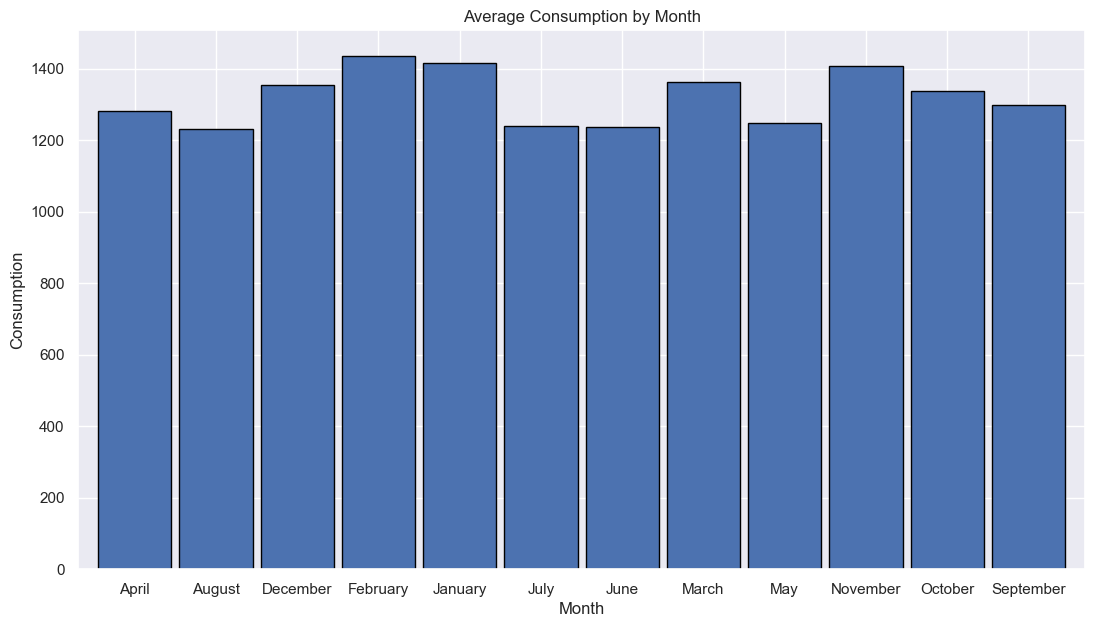

In [33]:
ax = y.groupby(y.index.month_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Consumption by Month', xlabel='Month', ylabel='Consumption')
None

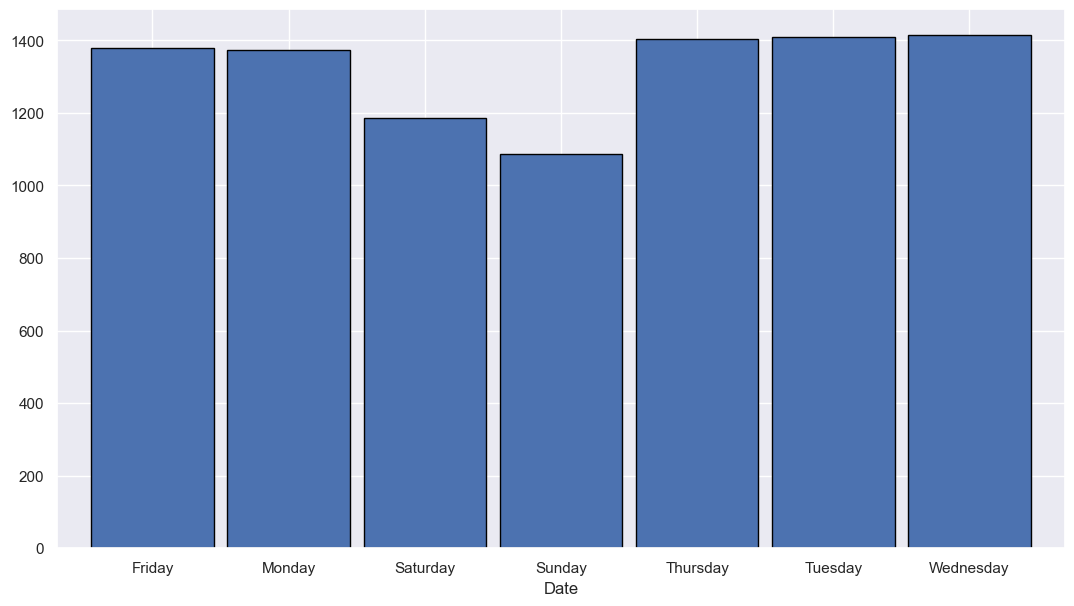

In [34]:
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Consumption by Weekday', xlabel='Weekday', ylabel='Consumption')
None

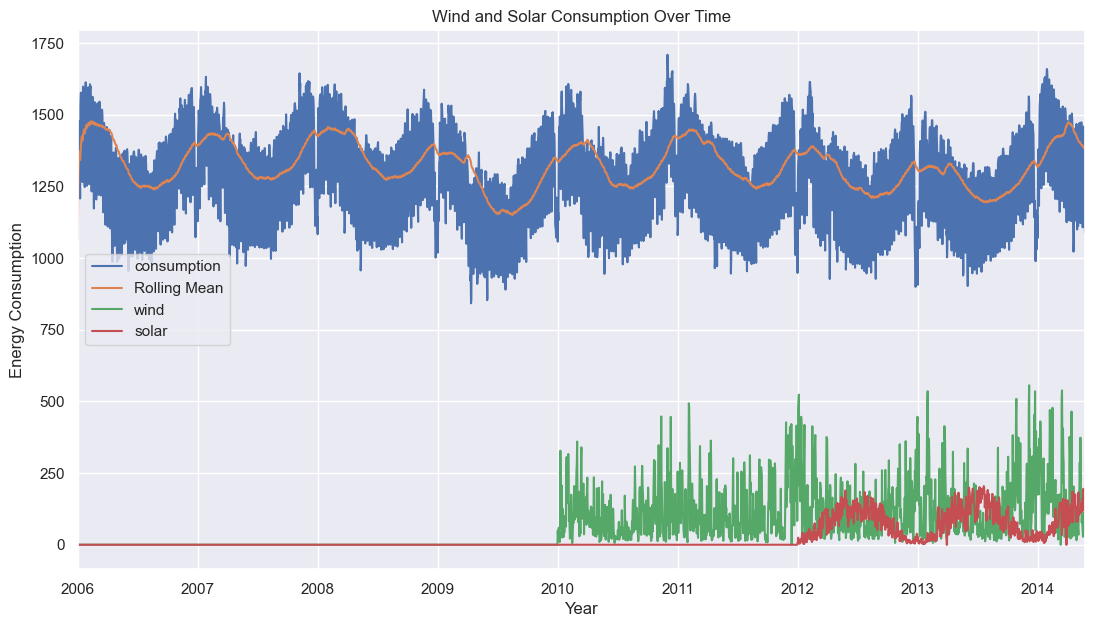

In [38]:
# plot the consumption, wind and solar data

train.consumption.plot(label="consumption")
plt.plot(train['consumption'].rolling('90D').mean(), label="Rolling Mean")
train.wind.plot()
train.solar.plot()

plt.title('Wind and Solar Consumption Over Time')
plt.ylabel('Energy Consumption')
plt.xlabel('Year')
plt.legend()
None

In [39]:
# make a new datafrsame sources
sources = train[['consumption', 'wind', 'solar']]

# make a new column called conventional: Consumption - Wind - Solar
sources['conventional'] = sources.consumption - sources.wind - sources.solar

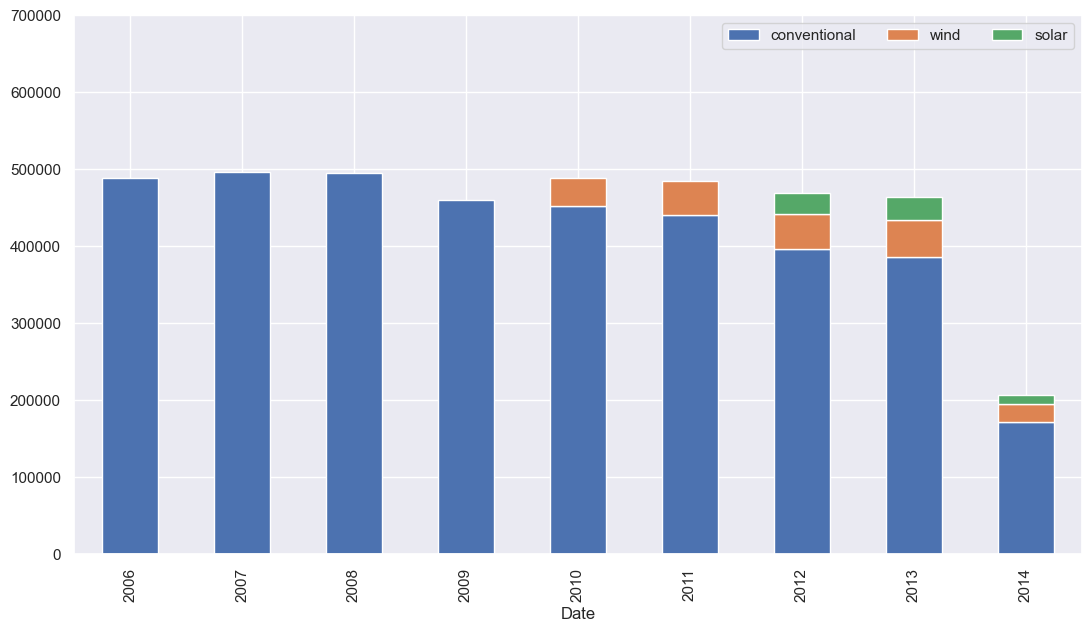

In [40]:
# lets plot the three power sources as stacked bar chart:

ax = sources[['conventional', 'wind', 'solar']].resample('Y').sum().plot.bar(stacked = True)
ax.set_ylim(0, 700000)
ax.legend(ncol = 3)

labels = [pd.to_datetime(t.get_text()).strftime('%Y') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels);